<a href="https://colab.research.google.com/github/IlfGauhnith/EC/blob/main/ICE_Lista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
!pip install deap imageio

In [318]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from deap import creator
from deap import base
from deap import tools
from deap import algorithms
from deap import benchmarks


import imageio
from IPython.display import Image
import os
import itertools

In [319]:
%matplotlib inline

# Questão 1

Um indivíduo é uma lista de oito valores inteiros no intervalo [0, 7] sem repetição.  

* Cada elemento da lista representa uma coluna das 8 colunas possíveis.  
* Cada índice da lista representa uma linha das 8 linhas possíveis.

Por exemplo: [5, 0, 3, 7, 2, 1, 4, 6]  
* linha 0, coluna 5
* linha 1, coluna 0
* linha 2, coluna 3
* linha 3, coluna 7
* linha 4, coluna 2
* linha 5, coluna 1
* linha 6, coluna 4
* linha 7, coluna 6

In [320]:
# FitnessMin é uma classe que herda de base.Fitness e tem o atributo weights.
# weights=(-1.0,) denota uma problema de minimização.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Individual é uma classe que herda de list e possui o atributo fitness que
# é uma instancia da classe FitnessMin definida anteriormente.
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [321]:
toolbox = base.Toolbox()

# attr_int é uma função que executa random.sample passando range(8) e 8 como parametros.
# random.sample funciona com uma amostragem sem reposição.
toolbox.register("attr_int", random.sample, range(8), 8)

# individual é uma função que executa tools.initIterate e passa creator.Individual e toolbox.attr_int como parametro.
# tools.initIterate executa creator.Individual passando como parâmetro o retorno de toolbox.attr_int
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_int)

# population é uma função que executa tools.initRepeat passando list e toolbox.individual como parametro.
# tools.initRepeat vai executar toolbox.individual uma quantidade n vezes passada por argumento e retornar como list.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Para criar uma população de 10 individuos aleatórios:
print(toolbox.population(10))


[[7, 2, 0, 5, 1, 6, 3, 4], [6, 4, 1, 2, 5, 0, 3, 7], [4, 3, 1, 2, 5, 0, 7, 6], [1, 2, 4, 6, 7, 5, 0, 3], [2, 4, 3, 0, 6, 7, 1, 5], [1, 4, 5, 6, 7, 2, 0, 3], [5, 6, 4, 1, 7, 2, 3, 0], [2, 1, 6, 4, 3, 5, 7, 0], [2, 0, 1, 5, 7, 6, 4, 3], [4, 6, 5, 1, 3, 7, 0, 2]]


Com a modelagem proposta a função de fitness torna-se trivial.  
Basta contar os conflitos na diagonal.

In [322]:
def count_diagonal_collision(individual):

  collisions = 0

  for current_queen in enumerate(individual):
    for queen in enumerate(individual):

      if current_queen != queen:
        row_diff = abs(current_queen[0] - queen[0])
        col_diff = abs(current_queen[1] - queen[1])

        if row_diff == col_diff:
          collisions += 1

  # Uma colisão é contada 2 vezes.
  collisions = collisions // 2

  return collisions,

In [323]:
# evaluate é uma função que executa count_diagonal_collision
toolbox.register("evaluate", count_diagonal_collision)


# Definindo operadores genéticos
# Recombinação
toolbox.register("mate", tools.cxOnePoint)

# Mutação
# Swap com 10% de chance para cada índice dado que o indíviduo já foi selecionado para mutação.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# Seleção dos pais
toolbox.register("select", tools.selTournament, tournsize=5)

Text(0.5, 1.0, 'cxOnePoint, mutShuffleIndexes, selTournament')

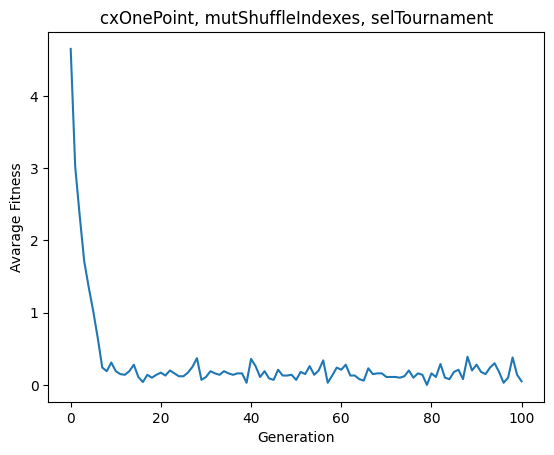

In [324]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

In [325]:
print(f"Best individual: {hof[0]}")
print(f"Its fitness: {count_diagonal_collision(hof[0])[0]}")

Best individual: [3, 5, 0, 4, 1, 5, 5, 2]
Its fitness: 0


## Comparação

Plotando a curva de fitness da combinação de diferentes operadores genéticos e salvando em 8queens-animation.gif.

In [326]:
mating = [tools.cxOnePoint, tools.cxTwoPoint, tools.cxUniform, tools.cxPartialyMatched]
mutation = [tools.mutShuffleIndexes]
selection = [tools.selTournament, tools.selRoulette]

image_dir = os.getcwd()
frames = []

for idx, (mate, mutate, select) in enumerate(itertools.product(mating, mutation, selection)):
  if mate == tools.cxUniform:
    toolbox.register("mate", mate, indpb=0.1)
  else:
    toolbox.register("mate", mate)

  toolbox.register("mutate", mutate, indpb=0.1)

  if select == tools.selTournament:
    toolbox.register("select", select, tournsize=5)
  else:
    toolbox.register("select", select)

  stats = tools.Statistics(lambda ind: ind.fitness.values)

  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  pop = toolbox.population(n=100)
  hof = tools.HallOfFame(1)

  pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                    stats=stats, verbose=False)
  experiment = pd.DataFrame(logbook)

  plt.plot(experiment["gen"], experiment["avg"])
  plt.xlabel("Generation")
  plt.ylabel("Avarage Fitness")
  plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

  plt.savefig(f"temp_{idx}")
  plt.clf()

  image = imageio.imread(os.path.join(image_dir, f"temp_{idx}.png"))
  frames.append(image)

imageio.mimsave('8queens-animation.gif', frames, fps=0.15)

<ipython-input-326-2e58ed4aad54>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_dir, f"temp_{idx}.png"))
<ipython-input-326-2e58ed4aad54>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_dir, f"temp_{idx}.png"))
<ipython-input-326-2e58ed4aad54>:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im

<Figure size 640x480 with 0 Axes>

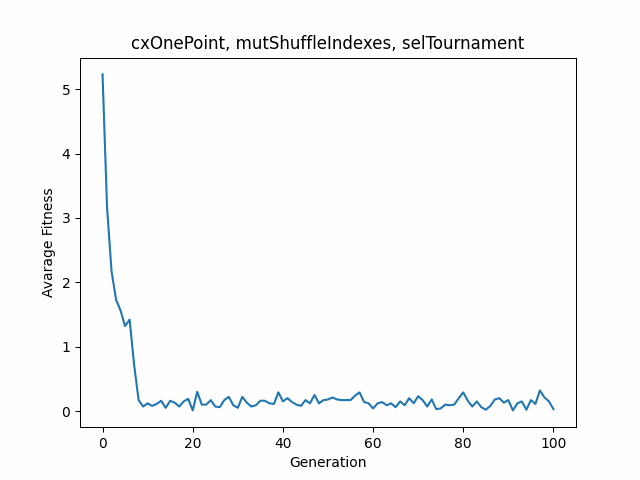

In [327]:
Image(open('8queens-animation.gif','rb').read())

A melhor combinação de operadores genéticos: **cxOnePoint, mutShuffleIndexes, selTournment**. Ela converge mais rápido do que a variante com cxTwoPoint.

# Questão 2

## Encontrar uma palavra secreta
O objetivo é encontrar a palavra **computer**

Um individuo é uma lista de inteiros no intervalo [97, 122] que representam todos os códigos ascii da letra 'a' até 'z'.

In [328]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [329]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.choices, population=range(ord('a'), ord('z')+1), k=8)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_int)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

A função de fitness é a contagem de letras corretas.

In [330]:
def correct_char_counter(individual):
  counter = [chr(current) == "computer"[idx] for idx, current in enumerate(individual)]
  return sum(counter),

In [331]:
# evaluate é uma função que executa count_diagonal_collision
toolbox.register("evaluate", correct_char_counter)


# Definindo operadores genéticos
# Recombinação
toolbox.register("mate", tools.cxOnePoint)

# Mutação
# Swap com 10% de chance para cada índice dado que o indíviduo já foi selecionado para mutação.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# Seleção dos pais
toolbox.register("select", tools.selTournament, tournsize=5)

Text(0.5, 1.0, 'cxOnePoint, mutShuffleIndexes, selTournament')

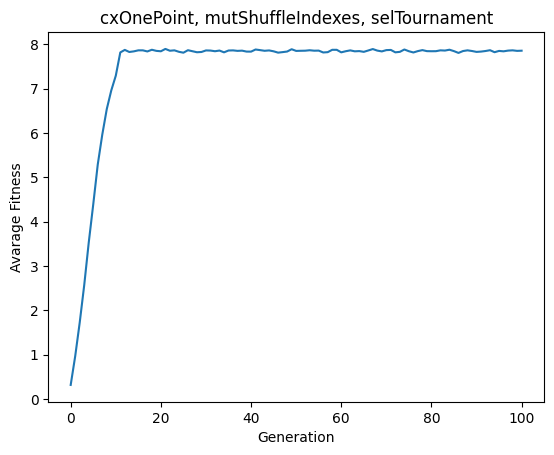

In [332]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

In [333]:
print(f"Best individual: {''.join([chr(c) for c in hof[0]])}")
print(f"Its fitness: {correct_char_counter([*hof[0]])[0]}")

Best individual: computer
Its fitness: 8


## Funções benchmark (ackley/griewank)

### Ackley

In [334]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [335]:
toolbox = base.Toolbox()

toolbox.register("attr", lambda a, b, k: [random.uniform(a, b) for _ in range(k)], a=-15, b=30, k=2)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [336]:
# evaluate é uma função que executa count_diagonal_collision
toolbox.register("evaluate", benchmarks.ackley)


# Definindo operadores genéticos
# Recombinação
toolbox.register("mate", tools.cxOnePoint)

# Mutação
# Swap com 10% de chance para cada índice dado que o indíviduo já foi selecionado para mutação.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# Seleção dos pais
toolbox.register("select", tools.selTournament, tournsize=5)

Text(0.5, 1.0, 'cxOnePoint, mutShuffleIndexes, selTournament')

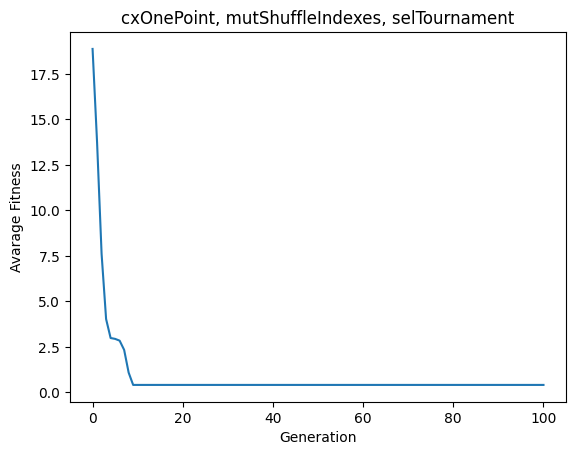

In [337]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

In [338]:
print(f"Best individual: {hof[0]}")
print(f"Its fitness: {benchmarks.ackley(hof[0])}")

Best individual: [-0.05832624779019646, -0.05832624779019646]
Its fitness: (0.4065906689387542,)


### griewank

In [339]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [340]:
toolbox = base.Toolbox()

toolbox.register("attr", lambda a, b, k: [random.uniform(a, b) for _ in range(k)], a=-600, b=600, k=2)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [341]:
# evaluate é uma função que executa count_diagonal_collision
toolbox.register("evaluate", benchmarks.ackley)


# Definindo operadores genéticos
# Recombinação
toolbox.register("mate", tools.cxOnePoint)

# Mutação
# Swap com 10% de chance para cada índice dado que o indíviduo já foi selecionado para mutação.
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)

# Seleção dos pais
toolbox.register("select", tools.selTournament, tournsize=5)

Text(0.5, 1.0, 'cxOnePoint, mutShuffleIndexes, selTournament')

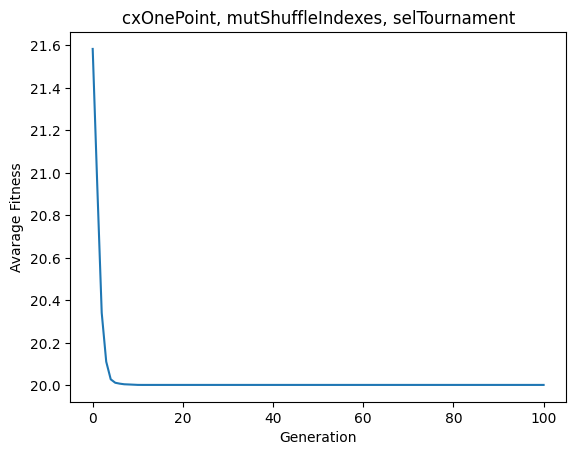

In [342]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

In [343]:
print(f"Best individual: {hof[0]}")
print(f"Its fitness: {benchmarks.ackley(hof[0])}")

Best individual: [110.99426430338588, 110.99426430338588]
Its fitness: (20.001764442242756,)


## Binário

In [344]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [345]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.choices, population=[0, 1], k=64)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_int)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [346]:
def count_ones(individual):
  counter = [bit == 1 for bit in individual]
  return sum(counter),

In [347]:
# evaluate é uma função que executa count_diagonal_collision
toolbox.register("evaluate", count_ones)


# Definindo operadores genéticos
# Recombinação
toolbox.register("mate", tools.cxOnePoint)

# Mutação
# Swap com 10% de chance para cada índice dado que o indíviduo já foi selecionado para mutação.
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)

# Seleção dos pais
toolbox.register("select", tools.selTournament, tournsize=5)

Text(0.5, 1.0, 'cxOnePoint, mutFlipBit, selTournament')

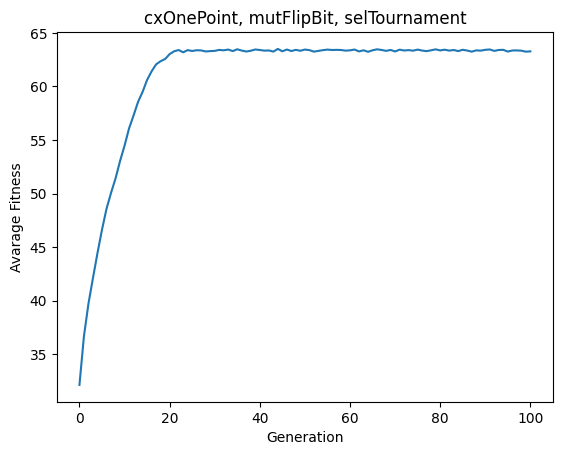

In [348]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")

In [349]:
print(f"Best individual: {hof[0]}")
print(f"Its fitness: {count_ones(hof[0])[0]}")

Best individual: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Its fitness: 64


## Caixeiro Viajante

Gerando distancias entre 100 cidades

In [350]:
NUMBER_OF_CITIES = 100
distances = np.zeros((NUMBER_OF_CITIES, NUMBER_OF_CITIES))
for city in range(NUMBER_OF_CITIES):
    cities = [ i for i in range(NUMBER_OF_CITIES) if not i == city ]
    for to_city in cities:
        distances[to_city][city] = \
            distances[city][to_city] = random.randint(50, 2000)

In [351]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [352]:
INDIVIDUAL_SIZE = 50

toolbox = base.Toolbox()

toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [353]:
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation,

toolbox.register("evaluate", EVALUATE)

In [354]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

Text(0.5, 1.0, 'cxOrdered, mutShuffleIndexes, selTournament')

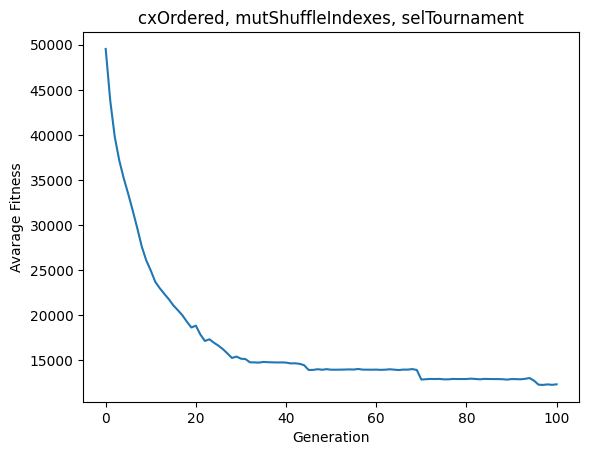

In [355]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=100,
                                   stats=stats, verbose=False, halloffame=hof)

experiment = pd.DataFrame(logbook)

plt.plot(experiment["gen"], experiment["avg"])
plt.xlabel("Generation")
plt.ylabel("Avarage Fitness")
plt.title(f"{toolbox.mate.func.__name__}, {toolbox.mutate.func.__name__}, {toolbox.select.func.__name__}")